In [25]:
import re

import geopandas as gpd
import pandas as pd
import h3
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

# Загрузка данных

In [26]:
gdf = gpd.read_file('data/240223_msk_center_36049.gpkg', crs=3857)
gdf = gdf[['cad_num', 'cost_value', 'year_built', 'floors', 'materials', 'purpose', 'build_record_area', 'geometry']]
gdf = gdf.rename(columns={'build_record_area': 'area'})
gdf.head()

,cad_num,cost_value,year_built,floors,materials,purpose,area,geometry
0,77:04:0003005:1022,3.905016e+08,2010,5,Каркасно-панельные,Нежилое,7567.8,"POLYGON ((4195017.494 7498783.131, 4195032.801..."
1,77:04:0003005:1058,8.518248e+08,1969,13,Кирпичные,Многоквартирный дом,4031.1,"POLYGON ((4194647.166 7499162.883, 4194683.544..."
2,77:04:0003005:1042,7.949180e+08,1975,12,Кирпичные,Многоквартирный дом,3497.4,"POLYGON ((4194600.186 7498928.372, 4194619.746..."
3,77:04:0003005:1032,5.519560e+06,1999,1,Крупнопанельные,Нежилое,186.1,"POLYGON ((4194614.025 7499062.188, 4194626.661..."
4,77:04:0003005:1043,8.654894e+08,1977,13,Кирпичные,Многоквартирный дом,3801.8,"POLYGON ((4194655.792 7499042.029, 4194691.758..."


In [27]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33158 entries, 0 to 33157
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   cad_num     33158 non-null  object  
 1   cost_value  33158 non-null  float64 
 2   year_built  33158 non-null  object  
 3   floors      33158 non-null  object  
 4   materials   33158 non-null  object  
 5   purpose     33158 non-null  object  
 6   area        33158 non-null  float64 
 7   geometry    33158 non-null  geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 2.0+ MB


Отфильтруем только те записи, где дома находятся в пределах ЦАО. Для этого нам понадобится геометрия районов ЦАО Москвы, которую можно с лёгкостью скачать с OSM. 

In [28]:
moscow_parts = gpd.read_file('data/moscow_parts.gpkg')

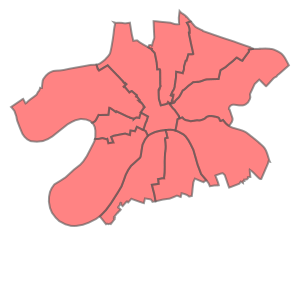

In [29]:
center_geometry = MultiPolygon(moscow_parts.geometry.values)
center_geometry

Отфильтруем только те дома, центроида геометрии которых лежит в пределах одного из районов ЦАО. 

In [30]:
gdf_2 = gdf[gdf.geometry.apply(lambda x: x.centroid.intersects(center_geometry))].copy()

In [31]:
gdf_2.shape

(17162, 8)

Из всего многообразия осталось 17 162 здания, что тоже хорошо. Теперь среди них уже можно определить район, к которому они принадлежат.  

In [32]:
def define_rayon(x):
    for i in range(moscow_parts.shape[0]):
        current_geo = moscow_parts.iloc[i]['geometry']
        if x.intersects(current_geo):
            return moscow_parts.iloc[i]['name']

In [33]:
gdf_2['rayon'] = gdf_2.geometry.apply(define_rayon)

Переведём год постройки дома в числовой формат. 

In [34]:
gdf_2['year_built'] = pd.to_numeric(gdf_2['year_built'])

Переведём количество этажей в числовой формат. Если у здания разная этажность отдельных его блоков, то будем брать максимальное количество этажей, так как в проекте хочется показать именно его.

In [35]:
gdf_2['floors'] = gdf_2['floors'].apply(lambda x: None if x == '' else x)

In [36]:
def floors_to_number(x):
    if isinstance(x, str):
        if x == 'Сведения отсутствуют':
            return None 
            
        # Пробуем преобразовать строку в число.
        # Это сработает, если строка состоит просто из числа
        try:
            return float(x)
        except ValueError:
            pass
        
        # Пробуем поделить запись на две части через дефис.
        # Это сработает в записях типа 17-21. 
        try:
            return float(x.split('-')[-1])
        except ValueError:
            pass
        
        # Пробуем выделить все числа, которые указаны в строке 
        # и найти максимальное среди них 
        try:
            return max(map(int, re.findall('(\d+)', x)))
        except ValueError:
            print(x)
            raise
        except TypeError:
            raise 
            
    else:
        return x

In [37]:
gdf_2['floors'] = gdf_2['floors'].apply(floors_to_number)

Очистим текстовые данные от пропусков, которые в наборе оформлены как пустые строки. 

In [38]:
gdf_2.materials = gdf_2['materials'].apply(lambda x: None if x == '' else x)
gdf_2.purpose = gdf_2['purpose'].apply(lambda x: None if x == '' else x)

Отфильтруем только те записи, в которых есть полная информация об объекте. 

In [39]:
gdf_2 = gdf_2[gdf_2.apply(lambda x: x.isna().sum() == 0, axis=1)]
gdf_2 = gdf_2.reset_index(drop=True)

Переведём датафрейм в проекцию карты EPSG:4326.

In [41]:
gdf_2 = gdf_2.to_crs(epsg=4326)

Сохраним итог. Данные готовы к тому, чтобы их анализировать :)

In [42]:
gdf_2.to_file('data/buildings.gpkg')

Обозначим центроиду.

In [141]:
gdf['center'] = gdf.geometry.apply(lambda x: x.centroid)

In [152]:
gdf['hex'] = gdf['center'].apply(lambda x: h3.geo_to_h3(x.x, x.y, 7))

hexes = gdf.groupby('hex', as_index=False)['cad_num'].count()
hexes['geometry'] = hexes['hex'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, False)))

hexes = gpd.GeoDataFrame(hexes, geometry='geometry', crs=4326)

print(hexes.shape)

hexes.explore(
    column='cad_num',
)

(64, 3)


In [148]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32254 entries, 0 to 32253
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   cad_num     32254 non-null  object  
 1   cost_value  32254 non-null  float64 
 2   year_built  32254 non-null  float64 
 3   floors      32254 non-null  float64 
 4   materials   32254 non-null  object  
 5   purpose     32254 non-null  object  
 6   area        32254 non-null  float64 
 7   geometry    32254 non-null  geometry
 8   center      32254 non-null  geometry
 9   hex         32254 non-null  object  
dtypes: float64(4), geometry(2), object(4)
memory usage: 2.5+ MB
